# Deblurring with a Total Variation Prior

In this notebook, we will explore the *Maximum a Posteriori* (MAP) estimator to solve the inverse problem of image deblurring. We will use a total variation (TV) prior and a positivity constraint to reconstruct a deblurred image. 

The forward model defining the instrumentation/acquisition is defined as:

$$\mathbf{y}=\mathbf{H}\mathbf{x}+\mathbf{n}$$

where:
- $\mathbf{y} \in \mathbb{R}^{d}$ is the observed blurred and noisy image,
- $\mathbf{H}: \mathbb{R}^{d\times d}$ is the blurring operator, which consists on a convolution with a point-spread-function (PSF),
- $\mathbf{x} \in \mathbb{R}^{d}$ is the original clean image we want to recover,
- $\mathbf{n} \in \mathbb{R}^{d}$ is independent and identically distributed Gaussian noise.

We will use a Gaussian kernel to simulate the blurring operator $\mathbf{H}$.

In [3]:
# Importing necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import skimage
from pyxu.operator import Convolve, L21Norm, Gradient, SquaredL2Norm, PositiveOrthant
from pyxu.opt.solver import PD3O
from pyxu.opt.stop import RelError, MaxIter

# Setting up GPU support
GPU = True
if GPU:
    import cupy as xp
else:
    import numpy as xp

## Loading and Preprocessing the Image

We will use a sample image from the `skimage.data` module and preprocess it to be suitable for the deblurring process. The image is converted to a float type and normalized to have pixel values between 0 and 1.

In [6]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
# Loading and preprocessing the image
data = skimage.data.coffee()
data = xp.asarray(data.astype("float32") / 255.0).transpose(2, 0, 1)

## Creating the Blurring Kernel

We will create a Gaussian blurring kernel (a.k.a. point spread function or PSF) to simulate the blurring effect of the camera lens on the image. The kernel is defined by its standard deviation and width. The Gaussian function is given by:
$$ G(x)=\frac{1}{2\pi\sigma^{2}} e^{−\frac{(x−\mu)^{2}}{2\sigma^{2}}} $$

where:
- $G(x)$ is the Gaussian function,
- $\sigma$ is the standard deviation,
- $\mu$ is the mean.

In [8]:
# Creating the Gaussian blurring kernel
sigma = 7
width = 13
mu = (width - 1) / 2
gauss = lambda x: (1 / (2 * np.pi * sigma**2)) * np.exp(
    -0.5 * ((x - mu) ** 2) / (sigma**2)
)

kernel_1d = np.fromfunction(gauss, (width,)).reshape(1, -1)
kernel_1d /= kernel_1d.sum()

kernel_1d = xp.asarray(kernel_1d)

## Applying the Blurring and Adding Noise

We will use the created Gaussian kernel to blur the image and then add Gaussian noise to simulate a real-world scenario where camera sensors are corrupted by thermal noise.

In [10]:
# Applying the blurring and adding noise
conv = Convolve(
    arg_shape=data.shape,
    kernel=[xp.array([1]), kernel_1d, kernel_1d],
    center=[0, width // 2, width // 2],
    mode="reflect",
    enable_warnings=True,
)
y = conv(data.ravel()).reshape(data.shape)
y = xp.random.normal(loc=y, scale=0.05)
y = y.clip(0, 1)

## MAP Approach with Total Variation Prior and Positivity Constraint

In the MAP approach, we aim to maximize the posterior distribution, which is the likelihood times the prior. The likelihood model is based on the noise distribution (Gaussian), and the prior model incorporates our assumptions about the image. The total variation prior promotes piecewise flat solutions, helping to preserve edges while smoothing out noise. The positivity constraint ensures that the pixel values of the deblurred image remain non-negative.

The optimization problem can be written as:
$$\hat{\mathbf{x}}=\arg\min_{\mathbf{x} ≥0} \frac{1}{2}\Vert \mathbf{y}− \mathbf{H}\mathbf{x}\Vert^{2}_{2}+\lambda\Vert\nabla\mathbf{x}\Vert_{1}$$

where:

- $\Vert\mathbf{y}−\mathbf{H}\mathbf{x}\Vert$ is the squared $L2$-norm representing the data fidelity term (likelihood),
- $\Vert \nabla \mathbf{x}\Vert_{2, 1}$ is the total variation prior, where $L_{21}$-norm on the gradient computes: $\sqrt{\Vert \nabla_{x} \mathbf{x} \Vert_{1}^{2} + \Vert \nabla_{y} \mathbf{x}\Vert_{1}^{2}}$,
- $\lambda$ is the regularization parameter,
- $\mathbf{x}≥0$ is the positivity constraint.

In [11]:
# Setting up the MAP approach with total variation prior and positivity constraint
sl2 = SquaredL2Norm(dim=y.size).asloss(y.ravel())
loss = sl2 * conv

l21 = L21Norm(arg_shape=(2, *y.shape), l2_axis=(0, 1))

grad = Gradient(
    arg_shape=y.shape,
    directions=(1, 2),
    gpu=GPU,
    diff_method="fd",
    scheme="central",
    accuracy=3,
)

loss.diff_lipschitz = loss.estimate_diff_lipschitz()
loss.lipschitz = loss.estimate_lipschitz()

stop_crit = RelError(
            eps=1e-6,
            var="x",
            f=None,
            norm=2,
            satisfy_all=True,
        ) | MaxIter(5000)

positivity = PositiveOrthant(dim=y.size)
solver = PD3O(f=loss, g=positivity, h= 3e-2 * l21, K=grad, verbosity=500)
solver.fit(x0=y.ravel(), stop_crit=stop_crit)

# Getting the deblurred image
recons = solver.solution().reshape(y.shape)
recons /= recons.max()


/home/joan/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


INFO -- [2023-10-10 15:32:43.934687] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO -- [2023-10-10 15:32:49.253019] Iteration 500
	iteration: 500
	RelError[x]: 0.00019502454535061996
	N_iter: 501.0
INFO -- [2023-10-10 15:32:54.524707] Iteration 1_000
	iteration: 1000
	RelError[x]: 0.00011881195755907154
	N_iter: 1001.0
INFO -- [2023-10-10 15:32:59.810908] Iteration 1_500
	iteration: 1500
	RelError[x]: 8.235574656383463e-05
	N_iter: 1501.0
INFO -- [2023-10-10 15:33:05.005431] Iteration 2_000
	iteration: 2000
	RelError[x]: 5.865723215429534e-05
	N_iter: 2001.0
INFO -- [2023-10-10 15:33:10.219914] Iteration 2_500
	iteration: 2500
	RelError[x]: 4.336657398691451e-05
	N_iter: 2501.0
INFO -- [2023-10-10 15:33:15.442941] Iteration 3_000
	iteration: 3000
	RelError[x]: 3.289840962592717e-05
	N_iter: 3001.0
INFO -- [2023-10-10 15:33:20.669106] Iteration 3_500
	iteration: 3500
	RelError[x]: 2.5113300552468785e-05
	N_iter: 3501.0
INFO -- [2023-10-10 15:33:25.889301] Iteration 4_000


## Evaluating the Results

We will evaluate the quality of the deblurred image using metrics like Mean Squared Error (MSE), Structural Similarity Index (SSIM), and Peak Signal to Noise Ratio (PSNR). These metrics will help us quantify the effectiveness of our deblurring process.

In [12]:
# Evaluating the deblurred image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

if GPU:
    data = data.get()
    y = y.get()
    recons = recons.get()

data = data.transpose(1, 2, 0)
y = y.transpose(1, 2, 0)
recons = recons.clip(0,1)
recons = recons.transpose(1, 2, 0)

mse_y = mse(data, y)
ssim_y = ssim(data, y, channel_axis=2, data_range=1.)
psnr_y = psnr(data, y, data_range=1.)
mse_recons = mse(data, recons)
ssim_recons = ssim(data, recons, channel_axis=2, data_range=1.)
psnr_recons = psnr(data, recons, data_range=1.)


## Visualizing the Results

Finally, let's visualize the original image, the blurred and noisy image, and the deblurred image obtained using the MAP approach with a total variation prior and positivity constraint. We will also display the evaluation metrics for a comprehensive comparison.

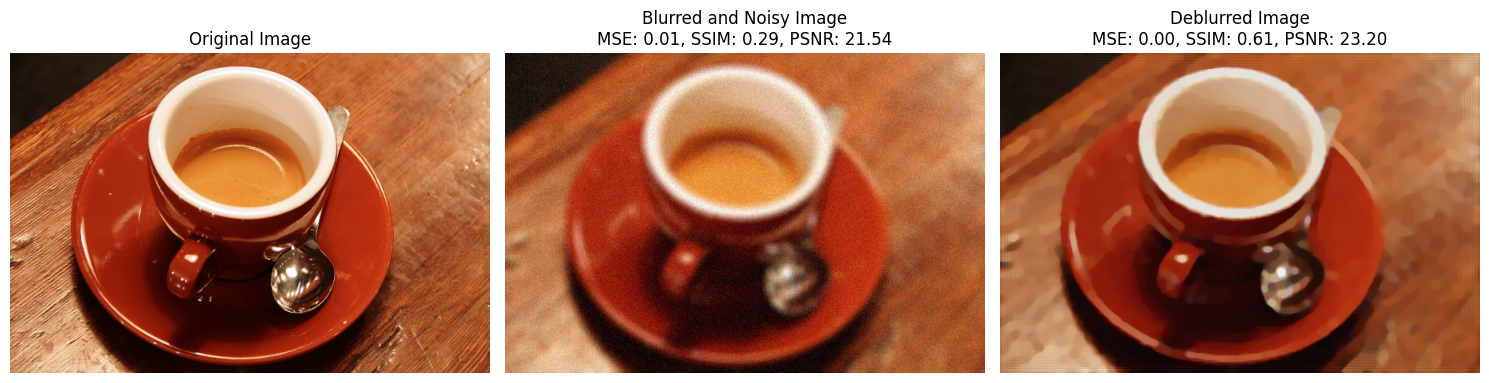

In [13]:
# Visualizing the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(data.clip(0,1))
axs[0].set_title("Original Image")

axs[1].imshow(y.clip(0, 1))
axs[1].set_title(f"Blurred and Noisy Image\nMSE: {mse_y:.2f}, SSIM: {ssim_y:.2f}, PSNR: {psnr_y:.2f}")

axs[2].imshow(recons)
axs[2].set_title(f"Deblurred Image\nMSE: {mse_recons:.2f}, SSIM: {ssim_recons:.2f}, PSNR: {psnr_recons:.2f}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
